## Feature extraction using ResNet-18

In [7]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from typing import Union, List

class ResNetFeatureExtractor:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained torchvision ResNet-18 and remove final fc layer
        resnet18 = models.resnet18(pretrained=True)
        self.model = torch.nn.Sequential(*(list(resnet18.children())[:-1]))  # Exclude final FC
        self.model = self.model.to(self.device)
        self.model.eval()

        # Use standard ImageNet preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Keep full context
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Optional but helpful
            transforms.ToTensor(),
            transforms.RandomRotation(degrees=15),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


    def extract_features(self, 
                         images: Union[str, Image.Image, List[str], List[Image.Image]], 
                         batch_size: int = 32) -> np.ndarray:
        if isinstance(images, (str, Image.Image)):
            images = [images]

        all_features = []
        image_batch = []

        # Load and preprocess images
        for img in images:
            if isinstance(img, str):
                pil_img = Image.open(img).convert("RGB")
            elif isinstance(img, Image.Image):
                pil_img = img.convert("RGB")
            else:
                raise ValueError(f"Unsupported image type: {type(img)}")

            tensor = self.transform(pil_img)
            image_batch.append(tensor)

        # Batch processing
        for i in range(0, len(image_batch), batch_size):
            batch_tensor = torch.stack(image_batch[i:i + batch_size]).to(self.device)  # Shape: (B, 3, 224, 224)

            with torch.no_grad():
                features = self.model(batch_tensor)  # Shape: (B, 512, 1, 1)
                features = features.view(features.size(0), -1)  # Shape: (B, 512)

            all_features.append(features.cpu().numpy())

        return np.concatenate(all_features, axis=0)

In [ ]:
import time
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torchvision
from os.path import join as j_

# get path to data
start = time.time()
dataroot = "D:\Aamir Gulzar\dataset\CRC100K"
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), 
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'NCT-CRC-HE-100K-NONORM'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'CRC-VAL-HE-7K'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

# create some image folder datasets for train/test and their data laoders
import torchvision
import os

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

# Use first 100 samples only for a quick test
# small_train_dataset = Subset(train_dataset, list(range(2000)))
# small_test_dataset = Subset(test_dataset, list(range(2000)))

# small_train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=32, shuffle=False, num_workers=2)
# small_test_loader = torch.utils.data.DataLoader(small_test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [9]:
import torch
import numpy as np
from tqdm import tqdm

def extract_patch_features_ResNet18(extractor, dataloader):
    extractor.model.eval()  # Ensure model is in eval mode
    device = extractor.device

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass through ResNet
            outputs = extractor.model(images)

            # Check if it's a tuple (for newer models that return BaseModelOutput)
            if isinstance(outputs, tuple) or hasattr(outputs, 'last_hidden_state'):
                features = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs[0]
            else:
                # Assume it's just the last feature vector
                features = outputs

            # Average pooling, if not already applied
            if features.ndim == 4:  # (B, C, H, W)
                features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
                features = features.view(features.size(0), -1)  # Flatten

            all_embeddings.append(features.cpu())
            all_labels.append(labels.cpu())

    return {
        'embeddings': torch.cat(all_embeddings, dim=0).numpy(),
        'labels': torch.cat(all_labels, dim=0).numpy()
    }


In [10]:
import numpy as np
import time

start = time.time()
extractor = ResNetFeatureExtractor()

train_features = extract_patch_features_ResNet18(extractor, train_dataloader)
test_features = extract_patch_features_ResNet18(extractor, test_dataloader)

train_feats = torch.tensor(train_features['embeddings'])
train_labels = torch.tensor(train_features['labels']).long()
test_feats = torch.tensor(test_features['embeddings'])
test_labels = torch.tensor(test_features['labels']).long()

elapsed = time.time() - start
print(f"Took {elapsed:.03f} seconds")
print(f"Train features shape {train_feats.shape}, Labels shape: {train_labels.shape}")
print(f"Test features shape {test_feats.shape}, Labels shape: {test_labels.shape}")

c:\Users\datainsight\anaconda3\envs\exaonepath\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\datainsight\anaconda3\envs\exaonepath\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 29/29 [01:32<00:00,  3.19s/it]

Took 1180.370 seconds
Train features shape torch.Size([100000, 512]), Labels shape: torch.Size([100000])
Test features shape torch.Size([7180, 512]), Labels shape: torch.Size([7180])


In [11]:
import os
import torch

# Create folder if it doesn't exist
resnet_dir = 'Resnet_features'
os.makedirs(resnet_dir, exist_ok=True)

# Save tensors
torch.save(train_feats, os.path.join(resnet_dir, 'train_feats.pt'))
torch.save(train_labels, os.path.join(resnet_dir, 'train_labels.pt'))
torch.save(test_feats, os.path.join(resnet_dir, 'test_feats.pt'))
torch.save(test_labels, os.path.join(resnet_dir, 'test_labels.pt'))

print("✅ resnet features and labels saved to 'Resnet_features/' folder.")

✅ resnet features and labels saved to 'Resnet_features/' folder.


In [1]:
import torch

# Folder path
resnet_dir = 'Resnet_features'

# Load tensors
train_feats = torch.load(f'{resnet_dir}/train_feats.pt')
train_labels = torch.load(f'{resnet_dir}/train_labels.pt')
test_feats = torch.load(f'{resnet_dir}/test_feats.pt')
test_labels = torch.load(f'{resnet_dir}/test_labels.pt')

In [12]:
import torch
from typing import Tuple, Dict, Any, List
import torch.nn.functional as F
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from UNI_main.metrics import get_eval_metrics  

from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, precision_score, recall_score, confusion_matrix
import pandas as pd
import os

import time
import torch
import pandas as pd
from typing import Tuple, Dict, Any
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, accuracy_score,
    balanced_accuracy_score, f1_score, precision_score,
    recall_score
)


class ANNClassifier:
    def __init__(self, input_dim=None, hidden_dim1=224, hidden_dim2=128, C=1.0, max_iter=100, verbose=True, random_state=42):
        self.C = C
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_dim = input_dim  # Will be set during fit() if None
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.model = None

    def compute_loss(self, preds, labels):
        loss = self.loss_func(preds, labels)
        wreg = 0.5 * sum((param.norm(p=2) for param in self.model.parameters()))  # L2 regularization
        return loss.mean() + (1.0 / self.C) * wreg

    def predict_proba(self, feats):
        feats = feats.to(self.device)
        with torch.no_grad():
            return torch.softmax(self.model(feats), dim=1)

    def fit(self, feats, labels):
        torch.manual_seed(self.random_state)
        np.random.seed(self.random_state)

        # Set input_dim if not set
        if self.input_dim is None:
            self.input_dim = feats.shape[1]

        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.hidden_dim1, self.hidden_dim2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.hidden_dim2, 9)  # Assuming 9 classes
        ).to(self.device)

        for layer in self.model:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)

        feats = feats.to(self.device)
        labels = labels.long().to(self.device)

        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)

        min_loss = np.inf
        patience = 10
        patience_counter = 0

        self.train_losses = []
        self.lr_schedule = []
        self.grad_norms = []

        for epoch in range(self.max_iter):
            self.model.train()
            opt.zero_grad()
            preds = self.model(feats)
            loss = self.compute_loss(preds, labels)
            loss.backward()

            # Gradient norm tracking
            total_norm = 0.0
            for p in self.model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            self.grad_norms.append(total_norm ** 0.5)

            opt.step()
            scheduler.step(loss)

            # Logging
            self.train_losses.append(loss.item())
            self.lr_schedule.append(opt.param_groups[0]['lr'])

            if self.verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss: {loss:.4f}, LR: {opt.param_groups[0]['lr']:.2e}, GradNorm: {self.grad_norms[-1]:.4f}")

            # Track best model
            if loss < min_loss:
                min_loss = loss
                patience_counter = 0
                best_model = self.model.state_dict()
            else:
                patience_counter += 1

            # Optional early stopping
            # if patience_counter >= patience:
            #     print(f"Early stopping at epoch {epoch}")
            #     break

        self.model.load_state_dict(best_model)

        if self.verbose:
            print(f"Final Loss: {min_loss:.4f}")
            self._plot_training_curves()


    def _plot_training_curves(self):
        plt.figure(figsize=(16, 4))

        # Plot 1: Training Loss
        plt.subplot(1, 3, 1)
        plt.plot(self.train_losses, label='Training Loss', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.grid(True)
        plt.legend()

        # Plot 2: Learning Rate
        plt.subplot(1, 3, 2)
        plt.plot(self.lr_schedule, label='Learning Rate', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.title('Learning Rate Schedule')
        plt.grid(True)
        plt.legend()

        # Plot 3: Gradient Norms
        plt.subplot(1, 3, 3)
        plt.plot(self.grad_norms, label='Gradient Norm', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('L2 Norm')
        plt.title('Gradient Norm Over Epochs')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

def eval_ANN_probe(
    train_feats: torch.Tensor,
    train_labels: torch.Tensor,
    valid_feats: torch.Tensor,
    valid_labels: torch.Tensor,
    test_feats: torch.Tensor,
    test_labels: torch.Tensor,
    max_iter: int = 1000,
    combine_trainval: bool = True,
    verbose: bool = True,
    save_path: str = None,
    hidden_dim1=224,
    hidden_dim2=128,
    C=1.0,
    save_metrics_csv: str = "ann_metrics.csv"
) -> Tuple[Dict[str, Any], Dict[str, Any]]:

    start = time.time()
    
    # Train the classifier
    classifier = train_ANN_probe(
        train_feats, train_labels,
        valid_feats, valid_labels,
        max_iter=max_iter,
        combine_trainval=combine_trainval,
        verbose=verbose,
        hidden_dim1=hidden_dim1,
        hidden_dim2=hidden_dim2,
        C=C
    )

    # Evaluate
    results, dump = test_ANN_probe(classifier, test_feats, test_labels, prefix="ann_", verbose=verbose)

    # Extract predictions and true labels
    preds = dump.get("preds_all")
    probs = dump.get("probs_all")
    targets = test_labels.cpu().numpy() if torch.is_tensor(test_labels) else test_labels

    # Metrics
    metrics = {
        "Accuracy": accuracy_score(targets, preds),
        "BalancedAccuracy": balanced_accuracy_score(targets, preds),
        "WeightedF1": f1_score(targets, preds, average='weighted'),
        "MacroF1": f1_score(targets, preds, average='macro'),
        "WeightedPrecision": precision_score(targets, preds, average='weighted'),
        "WeightedRecall": recall_score(targets, preds, average='weighted'),
    }

    # Optional: add ROC AUC
    try:
        metrics["ROC_AUC_macro"] = roc_auc_score(targets, probs, multi_class='ovo', average='macro')
    except Exception as e:
        if verbose:
            print(f"Could not compute ROC AUC: {e}")
        metrics["ROC_AUC_macro"] = None

    # Save metrics to CSV
    try:
        metrics_df = pd.DataFrame([metrics])
        metrics_df.to_csv(save_metrics_csv, index=False)
        if verbose:
            print("📊 Metrics saved to:", save_metrics_csv)
    except Exception as e:
        if verbose:
            print(f"Could not save metrics CSV: {e}")

    # Move model to CPU for saving
    classifier.model = classifier.model.to(torch.device("cpu"))
    dump["model"] = classifier.model.state_dict()

    if save_path is not None:
        try:
            torch.save(classifier.model, save_path)
            if verbose:
                print(f"✅ Model saved at: {save_path}")
        except Exception as e:
            if verbose:
                print(f"❌ Failed to save model: {e}")

    del classifier
    torch.cuda.empty_cache()

    if verbose:
        print(f"✅ ANN Probe Evaluation complete in {time.time() - start:.2f} seconds.")

    return metrics, dump


def train_ANN_probe(
    train_feats,
    train_labels,
    valid_feats,
    valid_labels,
    max_iter=1000,
    combine_trainval=True,
    verbose=True,
    hidden_dim1=224,
    hidden_dim2=128,
    C=1.0,
):
    if combine_trainval and valid_feats is not None:
        trainval_feats = torch.cat([train_feats, valid_feats], dim=0)
        trainval_labels = torch.cat([train_labels, valid_labels], dim=0)
        if verbose:
            print("Combining train and validation sets. Trainval shape: ", trainval_feats.shape)
        classifier = ANNClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, C=C, max_iter=max_iter, verbose=verbose)
        classifier.fit(trainval_feats, trainval_labels)
    else:
        classifier = ANNClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, C=C, max_iter=max_iter, verbose=verbose)
        classifier.fit(train_feats, train_labels)
    return classifier

def test_ANN_probe(
    classifier: ANNClassifier,
    test_feats: torch.Tensor,
    test_labels: torch.Tensor,
    prefix: str = "ann_",
    verbose: bool = True,
) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    if verbose:
        print(f"ANN Probe Evaluation: Test shape {test_feats.shape}")

    probs_all = classifier.predict_proba(test_feats).cpu().numpy()
    preds_all = np.argmax(probs_all, axis=1)
    targets_all = test_labels.cpu().numpy()
    roc_kwargs = {"multi_class": "ovo", "average": "macro"}
    # ⬇️ Calculate accuracy
    accuracy = np.mean(preds_all == targets_all)
    print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

    # ⬇️ Eval metrics
    eval_metrics = get_eval_metrics(targets_all, preds_all, probs_all, True, prefix, roc_kwargs)
    dump = {"preds_all": preds_all, "probs_all": probs_all, "targets_all": targets_all}

    # ⬇️ Confusion matrix
    conf_matrix = confusion_matrix(targets_all, preds_all)
    print("Confusion Matrix:")
    plot_confusion_matrix(conf_matrix)
    
    # ⬇️ New plots for deeper insight
    plot_classification_report(targets_all, preds_all)
    plot_roc_multiclass(targets_all, probs_all, n_classes=9)
    plot_prediction_confidence(probs_all, preds_all, targets_all)


    return eval_metrics, dump

    
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [13]:
from sklearn.metrics import classification_report
import pandas as pd

def plot_classification_report(y_true, y_pred, target_names=None):
    report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Classification Report")
    plt.show()
    
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_roc_multiclass(y_true, y_score, n_classes):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(sns.color_palette("husl", n_classes))
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_prediction_confidence(probs, preds, targets):
    confidences = probs[np.arange(len(preds)), preds]
    correct = preds == targets

    plt.figure(figsize=(10, 6))
    sns.histplot(confidences[correct], color='green', label='Correct', kde=True, stat='density')
    sns.histplot(confidences[~correct], color='red', label='Incorrect', kde=True, stat='density')
    plt.xlabel("Prediction Confidence")
    plt.ylabel("Density")
    plt.title("Prediction Confidence Distribution")
    plt.legend()
    plt.grid(True)
    plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from itertools import product
import json
import os

def ann_grid_search(
    train_feats, train_labels,
    test_feats, test_labels,
    validation_split=0.2,
    seed=42,
    experiment_name="Resnet-18_Exp1",  # 🆕 Add this to tag your run
    save_dir="best_parameters"     # 🆕 Directory for saving results
):
    os.makedirs(save_dir, exist_ok=True)
    # Split train_feats into training and validation parts
    train_idx, val_idx = train_test_split(
        np.arange(train_feats.shape[0]),
        test_size=validation_split,
        random_state=seed,
        stratify=train_labels.cpu().numpy()  # Preserves class distribution
    )
    train_feats_split = train_feats[train_idx]
    train_labels_split = train_labels[train_idx]
    val_feats_split = train_feats[val_idx]
    val_labels_split = train_labels[val_idx]

    # Grid parameters
    hidden_dim1_vals = [128, 224, 256]
    hidden_dim2_vals = [64, 128]
    C_vals = [0.1, 1.0, 10.0]
    max_iter_vals = [500]

    best_score = -np.inf
    best_params = None
    best_classifier = None

    for h1, h2, c, m in product(hidden_dim1_vals, hidden_dim2_vals, C_vals, max_iter_vals):
        print(f"Trying: hidden_dim1={h1}, hidden_dim2={h2}, C={c}, max_iter={m}")
        classifier = ANNClassifier(
            hidden_dim1=h1,
            hidden_dim2=h2,
            C=c,
            max_iter=m,
            verbose=False
        )
        classifier.fit(train_feats_split, train_labels_split)

        # Evaluate on validation set
        probs = classifier.predict_proba(val_feats_split).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        targets = val_labels_split.cpu().numpy()
        acc = np.mean(preds == targets)

        print(f"Validation Accuracy: {acc:.4f}")

        if acc > best_score:
            best_score = acc
            best_params = {'hidden_dim1': h1, 'hidden_dim2': h2, 'C': c, 'max_iter': m}
            best_classifier = classifier

    best_params_path = os.path.join(save_dir, f"{experiment_name}_best_params.json")
    with open(best_params_path, 'w') as f:
        json.dump(best_params, f, indent=4)

    print(f"📁 Saved best parameters to: {best_params_path}")

    print("\n✅ Best Parameters:", best_params)
    print("📈 Best Validation Accuracy:", best_score)
    return best_params, best_classifier

In [15]:
best_params, _ = ann_grid_search(
    train_feats=train_feats,
    train_labels=train_labels,
    test_feats=test_feats,
    test_labels=test_labels,
    experiment_name="Resnet-18"
)

Trying: hidden_dim1=128, hidden_dim2=64, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=64, C=1.0, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=64, C=10.0, max_iter=500
Validation Accuracy: 0.8956
Trying: hidden_dim1=128, hidden_dim2=128, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=128, C=1.0, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=128, hidden_dim2=128, C=10.0, max_iter=500
Validation Accuracy: 0.8985
Trying: hidden_dim1=224, hidden_dim2=64, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=64, C=1.0, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=64, C=10.0, max_iter=500
Validation Accuracy: 0.8992
Trying: hidden_dim1=224, hidden_dim2=128, C=0.1, max_iter=500
Validation Accuracy: 0.1041
Trying: hidden_dim1=224, hidden_dim2=128, C=1.0, max_iter=500
Validation Accuracy: 0.1041
Trying: hidde

In [ ]:
best_params= {'hidden_dim1': 224, 'hidden_dim2': 128, 'C': 10.0, 'max_iter': 500}
# hidden_dim1=128, hidden_dim2=160, C=0.01, max_iter=300 0.9593
# hidden_dim1=128, hidden_dim2=192, C=50.0, max_iter=1000 0.9596
# hidden_dim1=224, hidden_dim2=96, C=0.01, max_iter=300 0.9599
# hidden_dim1=256, hidden_dim2=192, C=0.01, max_iter=300 0.9655
# hidden_dim1=256, hidden_dim2=192, C=50.0, max_iter=1000 0.9667
# {'hidden_dim1': 512, 'hidden_dim2': 128, 'C': 50.0, 'max_iter': 1000} 0.96985

Epoch 0: Loss: 2.9074, LR: 1.00e-03, GradNorm: 3.4892
Epoch 10: Loss: 1.5544, LR: 1.00e-03, GradNorm: 0.8052
Epoch 20: Loss: 1.1004, LR: 1.00e-03, GradNorm: 0.4130
Epoch 30: Loss: 0.9050, LR: 1.00e-03, GradNorm: 0.2273
Epoch 40: Loss: 0.8020, LR: 1.00e-03, GradNorm: 0.1376
Epoch 50: Loss: 0.7427, LR: 1.00e-03, GradNorm: 0.1075
Epoch 60: Loss: 0.6990, LR: 1.00e-03, GradNorm: 0.0911
Epoch 70: Loss: 0.6678, LR: 1.00e-03, GradNorm: 0.0773
Epoch 80: Loss: 0.6420, LR: 1.00e-03, GradNorm: 0.0702
Epoch 90: Loss: 0.6208, LR: 1.00e-03, GradNorm: 0.0680
Epoch 100: Loss: 0.6033, LR: 1.00e-03, GradNorm: 0.0712
Epoch 110: Loss: 0.5875, LR: 1.00e-03, GradNorm: 0.0609
Epoch 120: Loss: 0.5739, LR: 1.00e-03, GradNorm: 0.0627
Epoch 130: Loss: 0.5628, LR: 1.00e-03, GradNorm: 0.0672
Epoch 140: Loss: 0.5527, LR: 1.00e-03, GradNorm: 0.0725
Epoch 150: Loss: 0.5420, LR: 1.00e-03, GradNorm: 0.1009
Epoch 160: Loss: 0.5310, LR: 1.00e-03, GradNorm: 0.0926
Epoch 170: Loss: 0.5212, LR: 1.00e-03, GradNorm: 0.1054
Epo

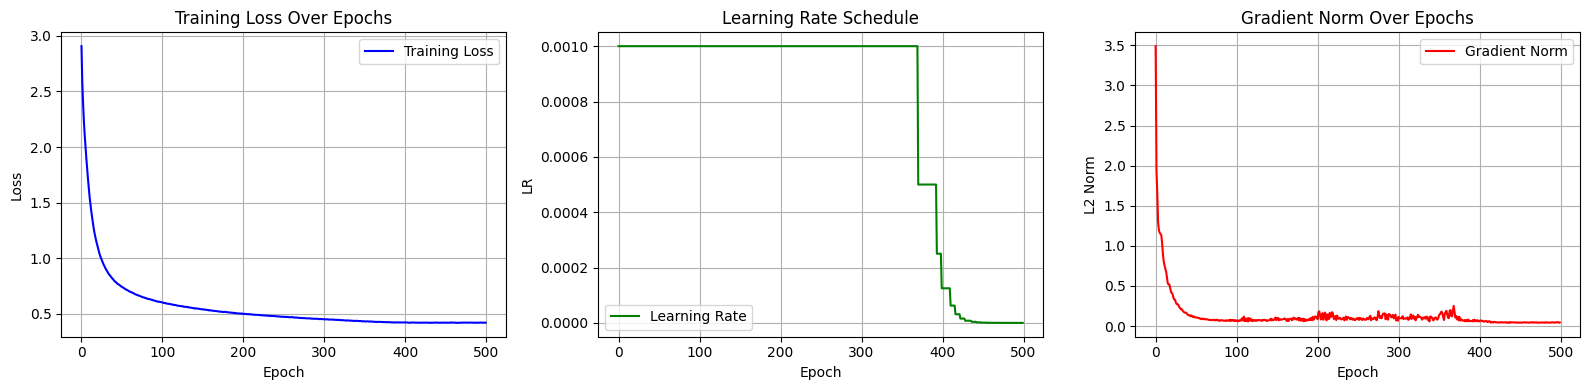

ANN Probe Evaluation: Test shape torch.Size([7180, 512])
✅ Test Accuracy: 70.06%
Confusion Matrix:


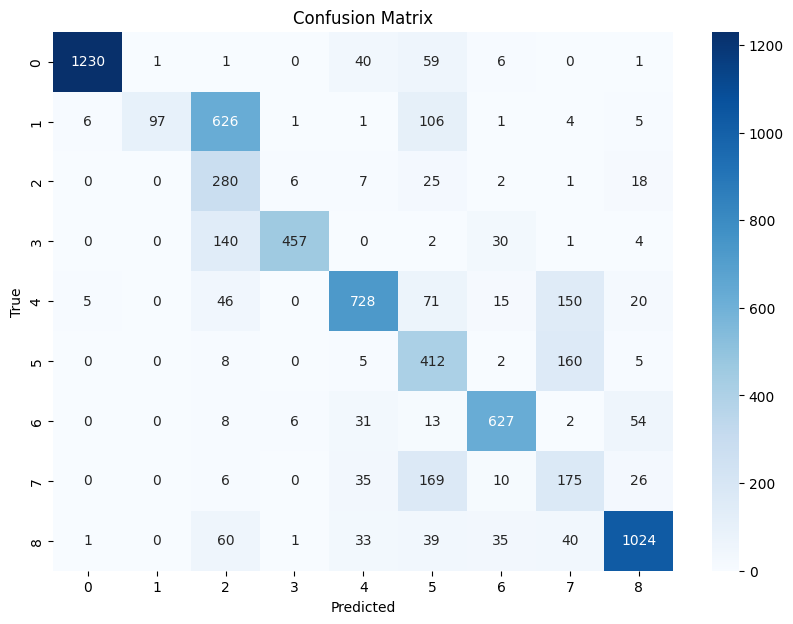

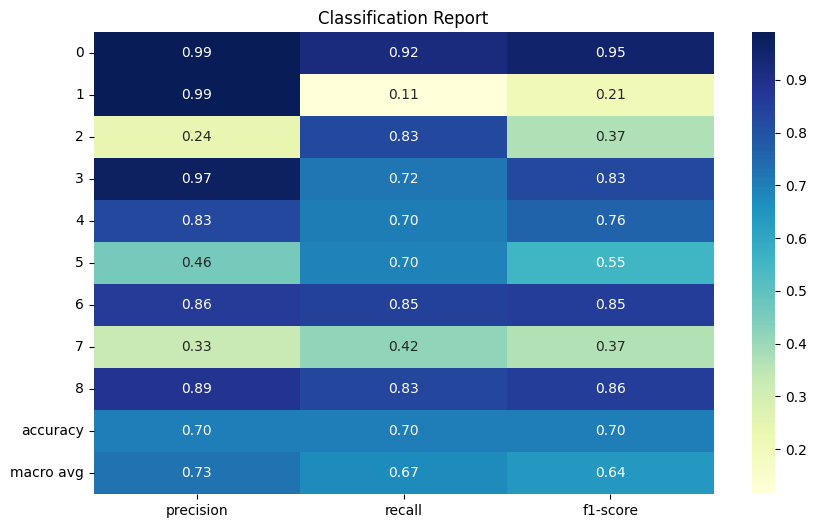

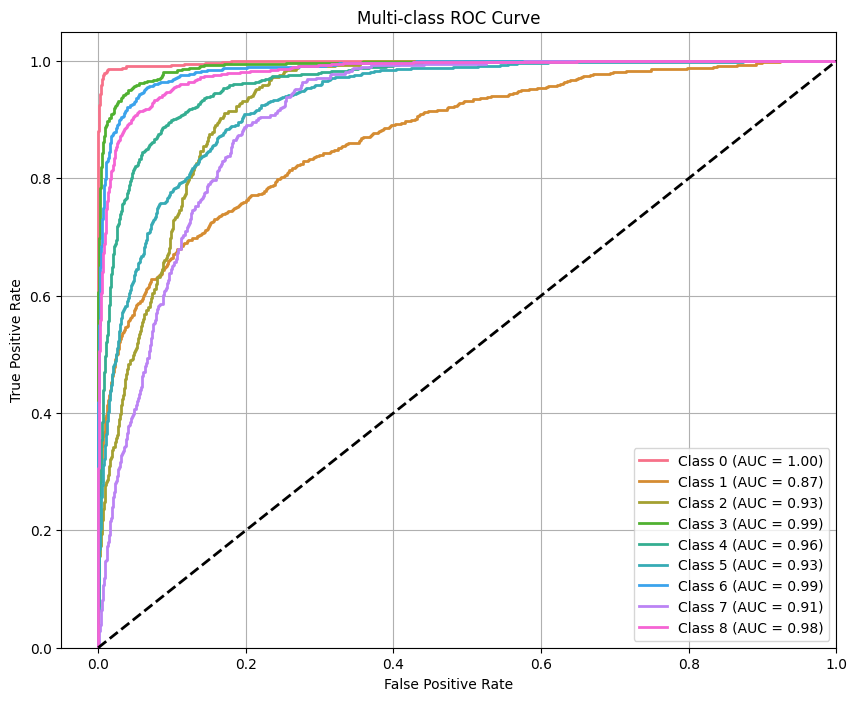

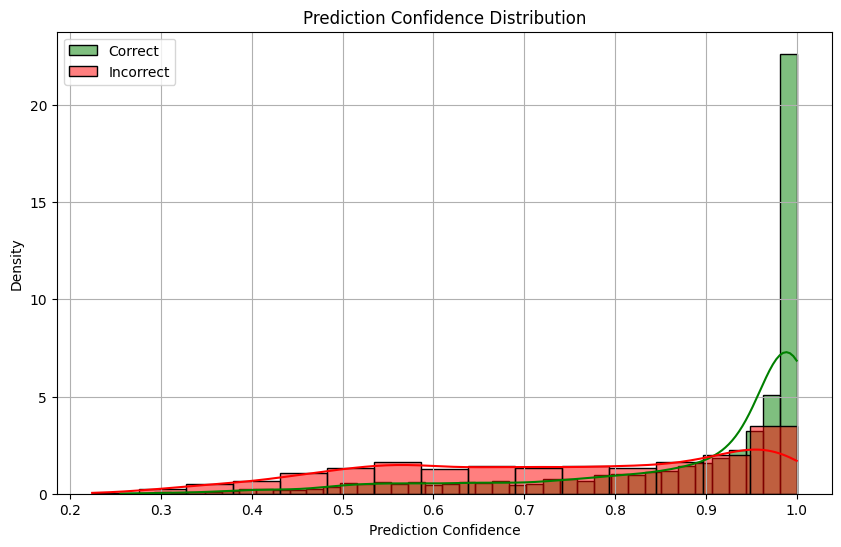

📊 Metrics saved to: model_metrics/eval_metrics.csv
✅ Model saved at: models/ann_resnet18_model.pth
✅ ANN Probe Evaluation complete in 3.88 seconds.


In [22]:
# Train final model on full training set with best parameters
metrics, trained_model = eval_ANN_probe(
    train_feats=train_feats,
    train_labels=train_labels,
    valid_feats=None,
    valid_labels=None,
    test_feats=test_feats,
    test_labels=test_labels,
    max_iter=best_params['max_iter'],
    hidden_dim1=best_params['hidden_dim1'],
    hidden_dim2=best_params['hidden_dim2'],
    C=best_params['C'],
    verbose=True,
    save_path='models/ann_resnet18_model.pth',
    save_metrics_csv='model_metrics/eval_metrics.csv'
)

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import pickle

# ========== CONFIGURATION ==========
patches_root = r"D:\DataInsight\CRC100k\patch_data_test"
features_root = r"D:\Titan_Project\Features_Tests\Custom_Method\3_small_slides_Conch_v1_5_FP"
non_white_csv = r"D:\Titan_Project\final_merged_without_white.csv"
ann_model_path = r"D:\DataInsight\CRC100k\ann_resnet18_model_exp1.pth"
output_slide_features = r"D:\DataInsight\CRC100k\Aggregated_slide_features_resnet18"
os.makedirs(output_slide_features, exist_ok=True)
num_groups = 9
feature_dim = 768
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ===================================

# Load ANN model
trained_model: ANNClassifier = torch.load(ann_model_path, map_location=device)
trained_model.eval()

# Load valid patch names
non_white_df = pd.read_csv(non_white_csv)
valid_patch_names = set(non_white_df['patch_name'].astype(str))

def is_non_white_patch(patch_path: str, valid_patch_names: set) -> int:
    patch_name = os.path.basename(patch_path)
    return int(patch_name in valid_patch_names)

def extract_coords(patch_name: str):
    try:
        base = os.path.splitext(patch_name)[0]
        parts = base.split('_')
        x = int([p for p in parts if p.startswith('x')][0][1:])
        y = int([p for p in parts if p.startswith('y')][0][1:])
        return x, y
    except Exception as e:
        print(f"❌ Error extracting coords from {patch_name}: {e}")
        return None, None
    
# Create directory to store patch group dictionaries
patch_groups_dir = r"D:\Titan_Project\Patch_groups_Exp1"
os.makedirs(patch_groups_dir, exist_ok=True)

# Main loop
for slide_name in tqdm(os.listdir(patches_root), desc="🔍 Processing slides"):
    # Path to save this slide's patch_group_dict
    patch_group_path = os.path.join(patch_groups_dir, f"patch_group_dict_{slide_name}.pkl")

    slide_patch_folder = os.path.join(patches_root, slide_name)
    if not os.path.isdir(slide_patch_folder):
        continue

    h5_path = os.path.join(features_root, slide_name, "patch_features", f"{slide_name}_patch_features.h5")
    if not os.path.exists(h5_path):
        print(f"⚠️ H5 file not found for {slide_name}")
        continue

    try:
        with h5py.File(h5_path, "r") as h5_file:
            coords = h5_file['coords'][:].squeeze(0)
            features = h5_file['features'][:].squeeze(0)

            coord_to_feat = {tuple(c): f for c, f in zip(coords, features)}

            patch_group_dict = {i: [] for i in range(num_groups)}

            for patch_file in os.listdir(slide_patch_folder):
                patch_path = os.path.join(slide_patch_folder, patch_file)
                if not patch_file.lower().endswith(".png"):
                    continue
                if is_non_white_patch(patch_path, valid_patch_names) == 0:
                    continue

                x, y = extract_coords(patch_file)
                if (x, y) in coord_to_feat:
                    current_feature = coord_to_feat[(x, y)]
                    input_tensor = torch.tensor(current_feature, dtype=torch.float32).unsqueeze(0).to(device)

                    with torch.no_grad():
                        output = trained_model(input_tensor)
                        predicted_group = torch.argmax(output, dim=1).item()
                        print(f"Predicted group for {patch_path} = " + str(predicted_group))

                    patch_group_dict[predicted_group].append(current_feature)
                else:
                    print(f"⚠️ Coordinates ({x}, {y}) not found in h5: {patch_file}")

            # Average features in each group
            group_features = []
            for group_id in range(num_groups):
                feats = patch_group_dict[group_id]
                if len(feats) > 0:
                    group_avg = np.mean(feats, axis=0)
                else:
                    group_avg = np.zeros(feature_dim)
                group_features.append(group_avg)

            # Final slide-level feature vector
            # This is basically the patch level features but averaged with its whole group, this is the aggregation method.
            slide_vector = np.stack(group_features, axis=0)  # shape: (9, 768)
            slide_tensor = torch.from_numpy(slide_vector)

            # Create directory for this slide
            slide_folder = os.path.join(output_slide_features, slide_name)
            os.makedirs(slide_folder, exist_ok=True)

            # Save as pt in folder
            torch.save(slide_tensor, os.path.join(slide_folder, f"{slide_name}.pt"))

            # Save patch_group_dict as .pkl
            with open(patch_group_path, 'wb') as f:
                pickle.dump(patch_group_dict, f)

            # method 1 : Use slide level classifier with the slide level feature vector.
            # method 2 : If we look at the distribution among the patches classes we can infer the class the whole slide belongs to.

    except Exception as e:
        print(f"❌ Error processing {h5_path}: {e}")

🔍 Processing slides: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

❌ Error processing D:\Titan_Project\Features_Tests\Custom_Method\3_small_slides_Conch_v1_5_FP\TCGA-3L-AA1B_nonMSIH\patch_features\TCGA-3L-AA1B_nonMSIH_patch_features.h5: mat1 and mat2 shapes cannot be multiplied (1x768 and 512x256)
❌ Error processing D:\Titan_Project\Features_Tests\Custom_Method\3_small_slides_Conch_v1_5_FP\TCGA-A6-5661_MSIH\patch_features\TCGA-A6-5661_MSIH_patch_features.h5: mat1 and mat2 shapes cannot be multiplied (1x768 and 512x256)
❌ Error processing D:\Titan_Project\Features_Tests\Custom_Method\3_small_slides_Conch_v1_5_FP\TCGA-AA-3846_nonMSIH\patch_features\TCGA-AA-3846_nonMSIH_patch_features.h5: mat1 and mat2 shapes cannot be multiplied (1x768 and 512x256)


## Tissue Classifier using ResNet-18, (CRC100k Upscaled to 512 method)

In [2]:
import time
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torchvision
from os.path import join as j_

# get path to example data
start = time.time()
dataroot = "D:\DataInsight\CRC100k\CRC100K_Smaller"
transform = transforms.Compose([
    transforms.Resize(512),  # Resize the image to 512x512
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # Normalize with ImageNet mean and std
])


# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'NCT-CRC-HE-100K-NONORM'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'CRC-VAL-HE-7K'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

# create some image folder datasets for train/test and their data laoders
import torchvision
import os

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

# Use first 2000 samples only for a quick test
small_train_dataset = Subset(train_dataset, list(range(2000)))
small_test_dataset = Subset(test_dataset, list(range(2000)))

small_train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=32, shuffle=False, num_workers=2)
small_test_loader = torch.utils.data.DataLoader(small_test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [4]:
import numpy as np

start = time.time()
extractor = ResNetFeatureExtractor()

train_features = extract_patch_features_ResNet18(extractor, train_dataloader)
test_features = extract_patch_features_ResNet18(extractor, test_dataloader)

train_feats = torch.tensor(train_features['embeddings'])
train_labels = torch.tensor(train_features['labels']).long()
test_feats = torch.tensor(test_features['embeddings'])
test_labels = torch.tensor(test_features['labels']).long()

elapsed = time.time() - start
print(f"Took {elapsed:.03f} seconds")
print(f"Train features shape {train_feats.shape}, Labels shape: {train_labels.shape}")
print(f"Test features shape {test_feats.shape}, Labels shape: {test_labels.shape}")

d:\miniconda_3\envs\CRC100K_Classifier_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda_3\envs\CRC100K_Classifier_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features:   0%|          | 0/7 [01:07<?, ?it/s]


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 4294967296 bytes.

In [ ]:
best_params, _ = ann_grid_search(
    train_feats=train_feats,
    train_labels=train_labels,
    test_feats=test_feats,
    test_labels=test_labels
)

Epoch 0: Loss: 5.0520
Epoch 10: Loss: 2.8539
Epoch 20: Loss: 2.2546
Epoch 30: Loss: 1.9614
Epoch 40: Loss: 1.8530
Epoch 50: Loss: 1.7324
Epoch 60: Loss: 1.6521
Epoch 70: Loss: 1.5988
Epoch 80: Loss: 1.5307
Epoch 90: Loss: 1.4861
Epoch 100: Loss: 1.4368
Epoch 110: Loss: 1.3960
Epoch 120: Loss: 1.3703
Epoch 130: Loss: 1.3225
Epoch 140: Loss: 1.2891
Epoch 150: Loss: 1.2585
Epoch 160: Loss: 1.2286
Epoch 170: Loss: 1.1915
Epoch 180: Loss: 1.1680
Epoch 190: Loss: 1.1357
Epoch 200: Loss: 1.1148
Epoch 210: Loss: 1.0798
Epoch 220: Loss: 1.0577
Epoch 230: Loss: 1.0360
Epoch 240: Loss: 1.0041
Epoch 250: Loss: 0.9847
Epoch 260: Loss: 0.9640
Epoch 270: Loss: 0.9409
Epoch 280: Loss: 0.9209
Epoch 290: Loss: 0.9052
Epoch 300: Loss: 0.8801
Epoch 310: Loss: 0.8638
Epoch 320: Loss: 0.8480
Epoch 330: Loss: 0.8260
Epoch 340: Loss: 0.8149
Epoch 350: Loss: 0.7978
Epoch 360: Loss: 0.7822
Epoch 370: Loss: 0.7695
Epoch 380: Loss: 0.7556
Epoch 390: Loss: 0.7382
Epoch 400: Loss: 0.7285
Epoch 410: Loss: 0.7211
Epo

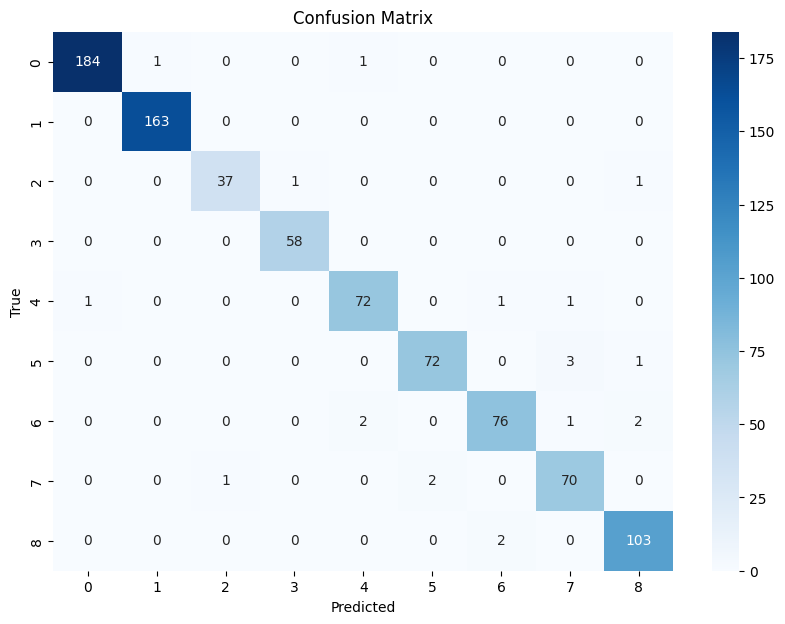

📊 Metrics saved to: eval_metrics.csv
✅ Model saved at: ann_resnet18_model.pth
✅ ANN Probe Evaluation complete in 30.08 seconds.


In [ ]:
# Train final model on full training set with best parameters
metrics, trained_model = eval_ANN_probe(
    train_feats=train_feats,
    train_labels=train_labels,
    valid_feats=None,
    valid_labels=None,
    test_feats=test_feats,
    test_labels=test_labels,
    max_iter=best_params['max_iter'],
    hidden_dim1=best_params['hidden_dim1'],
    hidden_dim2=best_params['hidden_dim2'],
    C=best_params['C'],
    verbose=True,
    save_path='ann_resnet18_model_Exp2.pth',
    save_metrics_csv='eval_metrics_ResNet18_Exp2.csv'
)

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import pickle

# ========== CONFIGURATION ==========
patches_root = r"D:\Titan_Project\Test_data_smaller"
features_root = r"D:\Titan_Project\Features_Tests\Custom_Method\3_small_slides_Conch_v1_5_FP"
non_white_csv = r"D:\Titan_Project\final_merged_without_white.csv"
ann_model_path = r"D:\DataInsight\CRC100k\ann_resnet18_model_exp1.pth"
output_slide_features = r"D:\Titan_Project\aggregated_slide_features_resnet18_exp1"
os.makedirs(output_slide_features, exist_ok=True)
num_groups = 9
feature_dim = 768
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ===================================

# Load ANN model
trained_model: ANNClassifier = torch.load(ann_model_path, map_location=device)
trained_model.eval()

# Load valid patch names
non_white_df = pd.read_csv(non_white_csv)
valid_patch_names = set(non_white_df['patch_name'].astype(str))

def is_non_white_patch(patch_path: str, valid_patch_names: set) -> int:
    patch_name = os.path.basename(patch_path)
    return int(patch_name in valid_patch_names)

def extract_coords(patch_name: str):
    try:
        base = os.path.splitext(patch_name)[0]
        parts = base.split('_')
        x = int([p for p in parts if p.startswith('x')][0][1:])
        y = int([p for p in parts if p.startswith('y')][0][1:])
        return x, y
    except Exception as e:
        print(f"❌ Error extracting coords from {patch_name}: {e}")
        return None, None
    
# Create directory to store patch group dictionaries
patch_groups_dir = r"D:\Titan_Project\Patch_groups_Exp1"
os.makedirs(patch_groups_dir, exist_ok=True)

# Main loop
for slide_name in tqdm(os.listdir(patches_root), desc="🔍 Processing slides"):
    # Path to save this slide's patch_group_dict
    patch_group_path = os.path.join(patch_groups_dir, f"patch_group_dict_{slide_name}.pkl")

    slide_patch_folder = os.path.join(patches_root, slide_name)
    if not os.path.isdir(slide_patch_folder):
        continue

    h5_path = os.path.join(features_root, slide_name, "patch_features", f"{slide_name}_patch_features.h5")
    if not os.path.exists(h5_path):
        print(f"⚠️ H5 file not found for {slide_name}")
        continue

    try:
        with h5py.File(h5_path, "r") as h5_file:
            coords = h5_file['coords'][:].squeeze(0)
            features = h5_file['features'][:].squeeze(0)

            coord_to_feat = {tuple(c): f for c, f in zip(coords, features)}

            patch_group_dict = {i: [] for i in range(num_groups)}

            for patch_file in os.listdir(slide_patch_folder):
                patch_path = os.path.join(slide_patch_folder, patch_file)
                if not patch_file.lower().endswith(".png"):
                    continue
                if is_non_white_patch(patch_path, valid_patch_names) == 0:
                    continue

                x, y = extract_coords(patch_file)
                if (x, y) in coord_to_feat:
                    current_feature = coord_to_feat[(x, y)]
                    input_tensor = torch.tensor(current_feature, dtype=torch.float32).unsqueeze(0).to(device)

                    with torch.no_grad():
                        output = trained_model(input_tensor)
                        predicted_group = torch.argmax(output, dim=1).item()
                        print(f"Predicted group for {patch_path} = " + str(predicted_group))

                    patch_group_dict[predicted_group].append(current_feature)
                else:
                    print(f"⚠️ Coordinates ({x}, {y}) not found in h5: {patch_file}")

            # Average features in each group
            group_features = []
            for group_id in range(num_groups):
                feats = patch_group_dict[group_id]
                if len(feats) > 0:
                    group_avg = np.mean(feats, axis=0)
                else:
                    group_avg = np.zeros(feature_dim)
                group_features.append(group_avg)

            # Final slide-level feature vector
            # This is basically the patch level features but averaged with its whole group, this is the aggregation method.
            slide_vector = np.stack(group_features, axis=0)  # shape: (9, 768)
            slide_tensor = torch.from_numpy(slide_vector)

            # Create directory for this slide
            slide_folder = os.path.join(output_slide_features, slide_name)
            os.makedirs(slide_folder, exist_ok=True)

            # Save as pt in folder
            torch.save(slide_tensor, os.path.join(slide_folder, f"{slide_name}.pt"))

            # Save patch_group_dict as .pkl
            with open(patch_group_path, 'wb') as f:
                pickle.dump(patch_group_dict, f)

            # method 1 : Use slide level classifier with the slide level feature vector.
            # method 2 : If we look at the distribution among the patches classes we can infer the class the whole slide belongs to.

    except Exception as e:
        print(f"❌ Error processing {h5_path}: {e}")

KeyboardInterrupt: 

## ANN trained on slide level feature vectors

##### What to do: 
##### Access the label and slide sheet.
##### Access slide name, then get its slide vector and train model to predict 418 slides
##### Use 4 fold cross validation 

In [ ]:
import torch
from typing import Tuple, Dict, Any, List
import torch.nn.functional as F
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from UNI_main.uni.downstream.eval_patch_features.metrics import get_eval_metrics
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, precision_score, recall_score, confusion_matrix
import pandas as pd
import os


class ANNClassifier:
    def __init__(self, input_dim=None, hidden_dim1=224, hidden_dim2=128, C=1.0, max_iter=100, verbose=True, random_state=42):
        self.C = C
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.max_iter = max_iter
        self.random_state = random_state
        self.verbose = verbose
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_dim = input_dim  # Will be set during fit() if None
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.model = None

    def compute_loss(self, preds, labels):
        loss = self.loss_func(preds, labels)
        wreg = 0.5 * sum((param.norm(p=2) for param in self.model.parameters()))  # L2 regularization
        return loss.mean() + (1.0 / self.C) * wreg

    def predict_proba(self, feats):
        feats = feats.to(self.device)
        with torch.no_grad():
            return torch.softmax(self.model(feats), dim=1)

    def fit(self, feats, labels):
        torch.manual_seed(self.random_state)
        np.random.seed(self.random_state)

        # Set input_dim if not set
        if self.input_dim is None:
            self.input_dim = feats.shape[1]

        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim1),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.hidden_dim1, self.hidden_dim2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(self.hidden_dim2, 2)  # Assuming 2 classes (MSIH, nonMSIH)
        ).to(self.device)

        for layer in self.model:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)

        feats = feats.to(self.device)
        labels = labels.long().to(self.device)

        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)

        min_loss = np.inf
        patience = 10
        patience_counter = 0

        for epoch in range(self.max_iter):
            opt.zero_grad()
            preds = self.model(feats)
            loss = self.compute_loss(preds, labels)
            loss.backward()
            opt.step()
            scheduler.step(loss)

            if self.verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss: {loss:.4f}")

            if loss < min_loss:
                min_loss = loss
                patience_counter = 0
                best_model = self.model.state_dict()
            else:
                patience_counter += 1

            # if patience_counter >= patience:
            #     print(f"Early stopping at epoch {epoch}")
            #     break

        self.model.load_state_dict(best_model)

        if self.verbose:
            print(f"Final Loss: {min_loss:.4f}")


import time
import torch
import pandas as pd
from typing import Tuple, Dict, Any
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, accuracy_score,
    balanced_accuracy_score, f1_score, precision_score,
    recall_score
)

def eval_ANN_probe(
    train_feats: torch.Tensor,
    train_labels: torch.Tensor,
    valid_feats: torch.Tensor,
    valid_labels: torch.Tensor,
    test_feats: torch.Tensor,
    test_labels: torch.Tensor,
    max_iter: int = 1000,
    combine_trainval: bool = True,
    verbose: bool = True,
    save_path: str = None,
    hidden_dim1=224,
    hidden_dim2=128,
    C=1.0,
    save_metrics_csv: str = "ann_metrics.csv"
) -> Tuple[Dict[str, Any], Dict[str, Any]]:

    start = time.time()
    
    # Train the classifier
    classifier = train_ANN_probe(
        train_feats, train_labels,
        valid_feats, valid_labels,
        max_iter=max_iter,
        combine_trainval=combine_trainval,
        verbose=verbose,
        hidden_dim1=hidden_dim1,
        hidden_dim2=hidden_dim2,
        C=C
    )

    # Evaluate
    results, dump = test_ANN_probe(classifier, test_feats, test_labels, prefix="ann_", verbose=verbose)

    # Extract predictions and true labels
    preds = dump.get("preds_all")
    probs = dump.get("probs_all")
    targets = test_labels.cpu().numpy() if torch.is_tensor(test_labels) else test_labels

    # Metrics
    metrics = {
        "Accuracy": accuracy_score(targets, preds),
        "BalancedAccuracy": balanced_accuracy_score(targets, preds),
        "WeightedF1": f1_score(targets, preds, average='weighted'),
        "MacroF1": f1_score(targets, preds, average='macro'),
        "WeightedPrecision": precision_score(targets, preds, average='weighted'),
        "WeightedRecall": recall_score(targets, preds, average='weighted'),
    }

    # Optional: add ROC AUC
    try:
        metrics["ROC_AUC_macro"] = roc_auc_score(targets, probs, multi_class='ovo', average='macro')
    except Exception as e:
        if verbose:
            print(f"Could not compute ROC AUC: {e}")
        metrics["ROC_AUC_macro"] = None

    # Save metrics to CSV
    try:
        metrics_df = pd.DataFrame([metrics])
        metrics_df.to_csv(save_metrics_csv, index=False)
        if verbose:
            print("📊 Metrics saved to:", save_metrics_csv)
    except Exception as e:
        if verbose:
            print(f"Could not save metrics CSV: {e}")

    # Move model to CPU for saving
    classifier.model = classifier.model.to(torch.device("cpu"))
    dump["model"] = classifier.model.state_dict()

    if save_path is not None:
        try:
            torch.save(classifier.model, save_path)
            if verbose:
                print(f"✅ Model saved at: {save_path}")
        except Exception as e:
            if verbose:
                print(f"❌ Failed to save model: {e}")

    del classifier
    torch.cuda.empty_cache()

    if verbose:
        print(f"✅ ANN Probe Evaluation complete in {time.time() - start:.2f} seconds.")

    return metrics, dump


def train_ANN_probe(
    train_feats,
    train_labels,
    valid_feats,
    valid_labels,
    max_iter=1000,
    combine_trainval=True,
    verbose=True,
    hidden_dim1=224,
    hidden_dim2=128,
    C=1.0,
):
    if combine_trainval and valid_feats is not None:
        trainval_feats = torch.cat([train_feats, valid_feats], dim=0)
        trainval_labels = torch.cat([train_labels, valid_labels], dim=0)
        if verbose:
            print("Combining train and validation sets. Trainval shape: ", trainval_feats.shape)
        classifier = ANNClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, C=C, max_iter=max_iter, verbose=verbose)
        classifier.fit(trainval_feats, trainval_labels)
    else:
        classifier = ANNClassifier(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, C=C, max_iter=max_iter, verbose=verbose)
        classifier.fit(train_feats, train_labels)
    return classifier

def test_ANN_probe(
    classifier: ANNClassifier,
    test_feats: torch.Tensor,
    test_labels: torch.Tensor,
    prefix: str = "ann_",
    verbose: bool = True,
) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    if verbose:
        print(f"ANN Probe Evaluation: Test shape {test_feats.shape}")

    probs_all = classifier.predict_proba(test_feats).cpu().numpy()
    preds_all = np.argmax(probs_all, axis=1)
    targets_all = test_labels.cpu().numpy()
    roc_kwargs = {"multi_class": "ovo", "average": "macro"}

    # ⬇️ Calculate accuracy
    accuracy = np.mean(preds_all == targets_all)
    print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

    # ⬇️ Eval metrics
    eval_metrics = get_eval_metrics(targets_all, preds_all, probs_all, True, prefix, roc_kwargs)
    dump = {"preds_all": preds_all, "probs_all": probs_all, "targets_all": targets_all}

    # ⬇️ Confusion matrix
    conf_matrix = confusion_matrix(targets_all, preds_all)
    print("Confusion Matrix:")
    plot_confusion_matrix(conf_matrix)

    return eval_metrics, dump

    
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

from sklearn.model_selection import train_test_split
from itertools import product

def ann_grid_search(
    train_feats, train_labels,
    test_feats, test_labels,
    validation_split=0.2,
    seed=42
):
    # Split train_feats into training and validation parts
    train_idx, val_idx = train_test_split(
        np.arange(train_feats.shape[0]),
        test_size=validation_split,
        random_state=seed,
        stratify=train_labels.cpu().numpy()  # Preserves class distribution
    )
    train_feats_split = train_feats[train_idx]
    train_labels_split = train_labels[train_idx]
    val_feats_split = train_feats[val_idx]
    val_labels_split = train_labels[val_idx]

    # Grid parameters
    hidden_dim1_vals = [128, 224, 256]
    hidden_dim2_vals = [64, 128]
    C_vals = [0.1, 1.0, 10.0]
    max_iter_vals = [500]

    best_score = -np.inf
    best_params = None
    best_classifier = None

    for h1, h2, c, m in product(hidden_dim1_vals, hidden_dim2_vals, C_vals, max_iter_vals):
        print(f"Trying: hidden_dim1={h1}, hidden_dim2={h2}, C={c}, max_iter={m}")
        classifier = ANNClassifier(
            hidden_dim1=h1,
            hidden_dim2=h2,
            C=c,
            max_iter=m,
            verbose=False
        )
        classifier.fit(train_feats_split, train_labels_split)

        # Evaluate on validation set
        probs = classifier.predict_proba(val_feats_split).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        targets = val_labels_split.cpu().numpy()
        acc = np.mean(preds == targets)

        print(f"Validation Accuracy: {acc:.4f}")

        if acc > best_score:
            best_score = acc
            best_params = {'hidden_dim1': h1, 'hidden_dim2': h2, 'C': c, 'max_iter': m}
            best_classifier = classifier

    print("\n✅ Best Parameters:", best_params)
    print("📈 Best Validation Accuracy:", best_score)
    return best_params, best_classifier

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# ======================== CONFIG ========================
label_csv_path = "Slide_Label_Data_V2.csv"
feature_dir = r"D:\DataInsight\CRC100k\aggregated_slide_features_Resnet18_exp1"
experiment_description = "Resnet-18_Exp1"
output_metrics_path = "eval_metrics_Resnet18_Exp1.csv"
output_params_path = "best_params_Resnet18_Exp1.csv"
save_model_root = "ann_models_Resnet18_Exp1"
os.makedirs(save_model_root, exist_ok=True)
# ========================================================

def load_slide_features_and_labels(label_csv, feature_dir):
    df = pd.read_csv(label_csv)
    features, labels, slide_names = [], [], []

    for _, row in df.iterrows():
        slide = row['Slide_name']
        label = int(row['isMSIH'])
        pt_path = os.path.join(feature_dir, slide, f"{slide}.pt")

        if os.path.exists(pt_path):
            feat = torch.load(pt_path)
            if feat.ndim == 2:
                feat = feat.flatten()  # shape: (9,768) → (6912,)
            features.append(feat)
            labels.append(label)
            slide_names.append(slide)
        else:
            print(f"⚠️ Feature file missing for slide {slide}")
    
    return torch.stack(features), torch.tensor(labels), slide_names


def run_crossval():
    all_feats, all_labels, slide_names = load_slide_features_and_labels(label_csv_path, feature_dir)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    all_metrics = []
    all_best_params = []

    for fold, (train_val_idx, test_idx) in enumerate(skf.split(all_feats, all_labels), start=1):
        print(f"\n📦 Fold {fold} running...")

        # Split
        train_val_feats, test_feats = all_feats[train_val_idx], all_feats[test_idx]
        train_val_labels, test_labels = all_labels[train_val_idx], all_labels[test_idx]

        # Grid Search
        best_params, _ = ann_grid_search(
            train_feats=train_val_feats,
            train_labels=train_val_labels,
            test_feats=test_feats,
            test_labels=test_labels
        )

        # Train final model with best params
        metrics, _ = eval_ANN_probe(
            train_feats=train_val_feats,
            train_labels=train_val_labels,
            valid_feats=None,
            valid_labels=None,
            test_feats=test_feats,
            test_labels=test_labels,
            max_iter=best_params['max_iter'],
            hidden_dim1=best_params['hidden_dim1'],
            hidden_dim2=best_params['hidden_dim2'],
            C=best_params['C'],
            verbose=True,
            save_path=os.path.join(save_model_root, f"fold{fold}_ann_model.pth"),
            save_metrics_csv=None  # We aggregate manually
        )

        # Append run results
        metrics['Fold'] = fold
        metrics['Description'] = experiment_description
        metrics['Timestamp'] = datetime.now().isoformat()
        all_metrics.append(metrics)

        best_params['Fold'] = fold
        best_params['Description'] = experiment_description
        best_params['Timestamp'] = datetime.now().isoformat()
        all_best_params.append(best_params)

    # Save all results
    pd.DataFrame(all_metrics).to_csv(output_metrics_path, index=False)
    pd.DataFrame(all_best_params).to_csv(output_params_path, index=False)

    print("\n✅ Cross-validation complete.")
    print(f"📊 Metrics saved to {output_metrics_path}")
    print(f"🔧 Best params saved to {output_params_path}")

if __name__ == "__main__":
    run_crossval()
